# radial quality control example

In [1]:
from hfradarpy.radials import Radial, qc_radial_file
import glob
import os
import xarray as xr

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
from matplotlib.colors import TwoSlopeNorm, Normalize
import requests
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
# Import matplotlib and cartopy
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm, Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable
from oceans.ocfis import uv2spdir, spdir2uv
from matplotlib import colors


# Import matplotlib and cartopy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## set paths

In [2]:
# Path to radial directory

root_pth = 'C:/Users/akaaw/airsea/data/jedi/hfradar/'
year = '2022/'
mnth = year[:4]+'03/'
site = 'Rutgers/BLCK/'
radial_dir = root_pth + year + mnth + site
save_dir =  root_pth + year + mnth + site + 'radials_qc/'
savepth = save_dir + 'radials.txt' #for plotting the raw radials
savepth = savepth.replace('/', '\\') #windows machine

n = 6 #file to test with

# Use glob to find radial files (*
files = sorted(glob.glob(os.path.join(radial_dir, '*.ruv')))
files[:10]

['C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0000.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0100.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0300.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0400.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0500.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0600.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0700.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0800.ruv',
 'C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK\\RDL_i_Rutgers_BLCK_2022_03_01_0900.ruv',
 'C:/Users/akaaw/ai

## Functions and tools

In [3]:
#url = 'https://www.ncei.noaa.gov/data/oceans/ndbc/hfradar/radial/2022/202203/Rutgers/BLCK/RDL_i_Rutgers_BLCK_2022_03_15_1700.ruv'
url = 'https://www.ncei.noaa.gov/data/oceans/ndbc/hfradar/radial/'+ year + mnth + site+ files[n][65:]

def load_data(file_path, encoding='utf-8'):
    '''
    This function loads the HFradar using pandas
    '''
    try:
        # Load the velocity data from the text file using pandas with the specified encoding
        data = pd.read_csv(file_path, comment='%', delimiter='\s+', header=None, encoding=encoding)
        
        return data
    except Exception as e:
        print("Failed to load data:", str(e))
        return None

    
def download_data(url, save_path):
    '''
    This function downloads the HFradar
    '''
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Send a GET request to the URL and download the data
    response = requests.get(url)
    if response.status_code == 200:
        content = response.content
        with open(save_path, 'wb') as file:
            file.write(content)
        #print("Data downloaded successfully.")
    else:
        print("Failed to download data. Response code:", response.status_code)


# Create a re-usable function for map features that we can pass an axes to.
def map_features(ax):
    # Axes properties and features
    extent =[-73.8, -69.1, 39.3, 42.1]
    ax.set_extent(extent)
    ax.add_feature(LAND, edgecolor=edgecolor, facecolor=landcolor)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines, zorder=11, edgecolor=edgecolor)

    # Gridlines and grid labels
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=.5,
        color='black',
        alpha=0.25,
        linestyle='--'
    )

    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 28, 'color': 'black'}
    gl.ylabel_style = {'size': 28, 'color': 'black'}
    gl.xlocator = mticker.MaxNLocator(integer=True)
    gl.ylocator = mticker.MaxNLocator(integer=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.tick_params(which='major',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   length=5, width=2)

    ax.tick_params(which='minor',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   width=1)
# Set colors of the land. 
edgecolor = 'black'
landcolor = 'white'

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='brown'
)

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

extent = []

dx = dy = 0.2  # Area around the point of interest.
      

## Load the raw ascii file for before QC plotting

In [4]:

"""
Displays the direction and magnitude of the radials
"""
cmap = cmocean.cm.balance
scale=50
headwidth=2.5
headlength=4
headaxislength=4
sub=1
velocity_min = -40
velocity_max = 40
cbar_step = 10
offset = Normalize(vmin=velocity_min, vmax=velocity_max, clip=True)


_ = download_data(url, savepth)
df =load_data(savepth)
Lon= df.iloc[:, 0]
Lat = df.iloc[:, 1]
U = df.iloc[:, 2]
V = df.iloc[:, 3]
Velo=  df.iloc[:, 15]

## Plot the before QC figure

C:\Users\akaaw\miniconda3\envs\expedition\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


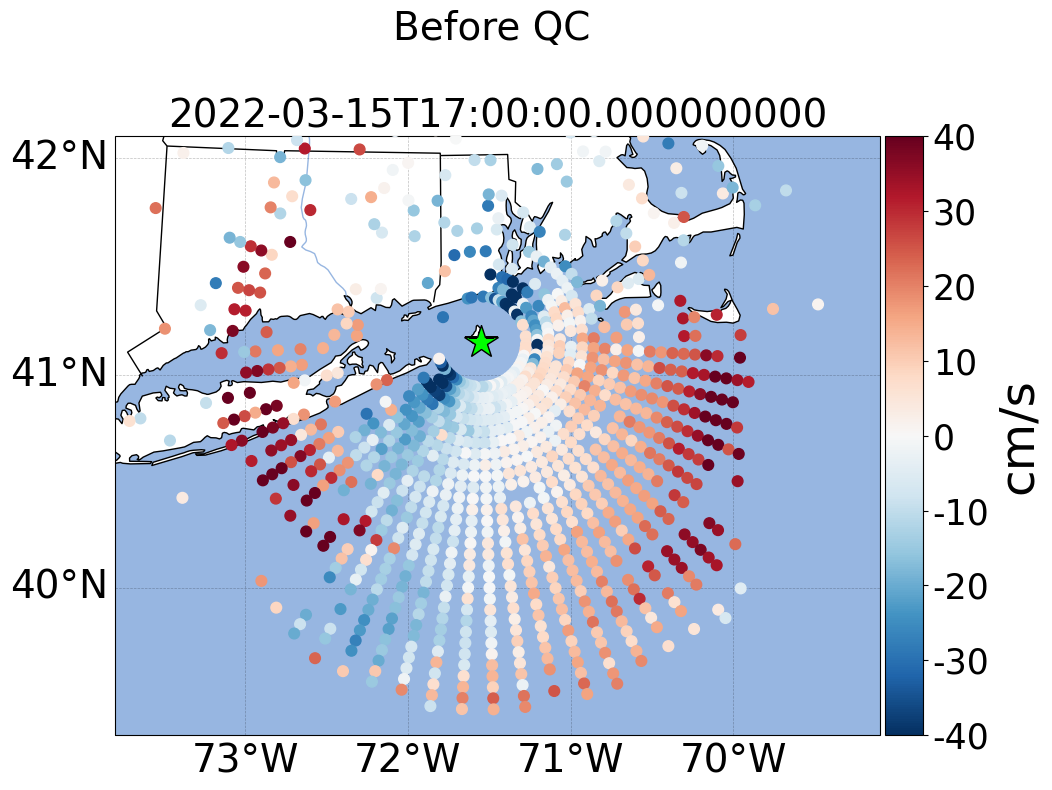

In [14]:

r = Radial(files[1000])
r

# run high frequency radar qartod tests on open radial file

qc_values = dict(
    qc_qartod_avg_radial_bearing=dict(reference_bearing=151, warning_threshold=15, failure_threshold=30),
    qc_qartod_radial_count=dict(min_count=75.0, low_count=225.0),
    qc_qartod_maximum_velocity=dict(max_speed=300.0, high_speed=100.0),
    qc_qartod_spatial_median=dict(smed_range_cell_limit=2.1, smed_angular_limit=10, smed_current_difference=30),
    qc_qartod_temporal_gradient=dict(gradient_temp_fail=32, gradient_temp_warn=25),
    qc_qartod_primary_flag=dict(include=['qc_qartod_syntax', 'qc_qartod_valid_location', 'qc_qartod_radial_count',
                                         'qc_qartod_maximum_velocity', 'qc_qartod_spatial_median'])
)
r.initialize_qc()
r.qc_qartod_syntax()
r.qc_qartod_maximum_velocity(**qc_values['qc_qartod_maximum_velocity'])
r.qc_qartod_valid_location()
r.qc_qartod_radial_count(**qc_values['qc_qartod_radial_count'])
r.qc_qartod_spatial_median(**qc_values['qc_qartod_spatial_median'])
r.qc_qartod_temporal_gradient(files[1]) #pass the previous hourly radial to this one
r.qc_qartod_avg_radial_bearing(**qc_values['qc_qartod_avg_radial_bearing'])
r.qc_qartod_primary_flag(**qc_values['qc_qartod_primary_flag'])

tds = r.to_xarray('gridded', enhance=True).squeeze()
tds


# Define arrow colors. Limited by velocity_min and velocity_max
color_clipped = np.clip(
    tds.velocity.data[::sub],
    velocity_min,
    velocity_max
).squeeze()

ticks = np.append(np.arange(velocity_min, velocity_max, cbar_step), velocity_max)

color_clippedfull = np.clip(
    Velo,
    velocity_min,
    velocity_max
).squeeze()


extent = [-73.8, -69.1, 39.3, 42.1]
    
offset = TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)

fig, ax = plt.subplots(
    figsize=(11, 8),
    subplot_kw=dict(projection=ccrs.Mercator())
)

# Plot title
plt.title(f'Before QC \n \n{tds.time.data}', fontsize = 28)
map_features(ax)

# plot circles instead of arrows
scatter_args = dict(
    cmap='RdBu_r',
    c= color_clippedfull,
    s=59,  # Adjust the size of the circles as needed
    transform=ccrs.PlateCarree(),
    norm=offset,zorder=11)




h = ax.scatter(Lon, Lat, **scatter_args)
# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('cm/s', fontsize = 35)

ax.tick_params(axis='both', labelsize=35)
cb.ax.tick_params(labelsize=25)
ax.plot( -71.55, 41.15, '*', markersize=25, markeredgecolor='black', color='lime', transform=ccrs.PlateCarree())
plt.tight_layout()
plt.savefig('raw_data.png', bbox_inches='tight')


## Save the QC radial as nc

In [6]:
save_file = save_dir + r.file_name[:-4:] + '.nc'
print('Saving NetCDF file: ' + save_file)
#tds.to_netcdf(save_file)

Saving NetCDF file: C:/Users/akaaw/airsea/data/jedi/hfradar/2022/202203/Rutgers/BLCK/radials_qc/RDL_m_Rutgers_BLCK_2022_03_15_1700.nc


In [7]:
# Lets get rid of the single time dimension. It will cause problems during plotting
tds = tds.squeeze()
extent = [tds.lon.min()-dx, tds.lon.max()+dx, tds.lat.min()-dy, tds.lat.max()+dy]

In [8]:
print(extent)

[<xarray.DataArray 'lon' ()>
array(-74.1795)
Coordinates:
    time     datetime64[ns] 2022-03-15T17:00:00, <xarray.DataArray 'lon' ()>
array(-68.9222)
Coordinates:
    time     datetime64[ns] 2022-03-15T17:00:00, <xarray.DataArray 'lat' ()>
array(39.1179)
Coordinates:
    time     datetime64[ns] 2022-03-15T17:00:00, <xarray.DataArray 'lat' ()>
array(43.1871)
Coordinates:
    time     datetime64[ns] 2022-03-15T17:00:00]


# Split out everything into seperate variables in order to pass them easier to the plotting functions

In [9]:

time = tds.time
lon = tds.coords['lon'].data
lat = tds.coords['lat'].data
u = tds['u'].data
v = tds['v'].data

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

The next step requires the oceans package.  If you don't have this package installed in the environment already, you will have to install it and then restart the kernel to run the next sections of code. 

In [10]:

angle, speed = uv2spdir(u, v)  # convert u/v to angle and speed

u, v = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speed),
    angle,
    deg=True
)

## Check the results of required QC implementation

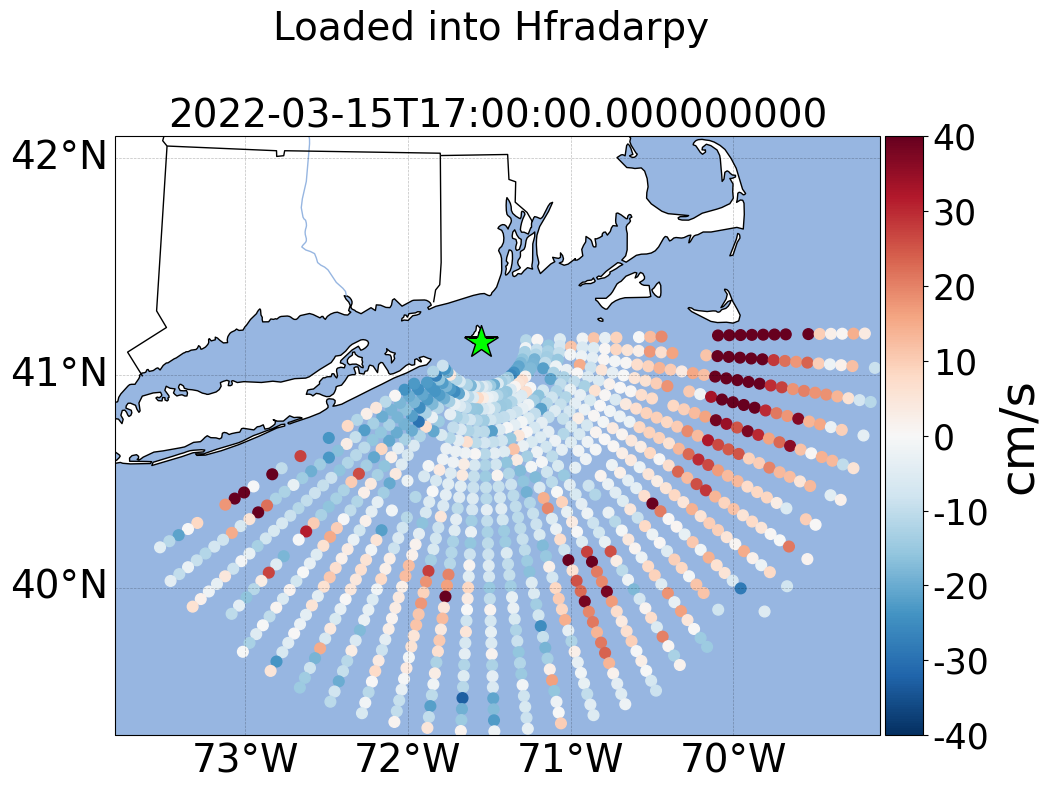

In [11]:
offset = TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)

fig, ax = plt.subplots(
    figsize=(11, 8),
    subplot_kw=dict(projection=ccrs.Mercator())
)

# Plot title
plt.title(f'Loaded into Hfradarpy \n \n{tds.time.data}', fontsize = 28)

# plot circles instead of arrows
scatter_args = dict(
    cmap='RdBu_r',
    c= tds.velocity,
    s=59,  # Adjust the size of the circles as needed
    transform=ccrs.PlateCarree(),
    norm=offset)
extent = [-76.2, -69, 38.9, 42.1]
#h = ax.scatter(r.data['LOND'][::sub], r.data['LATD'][::sub], **scatter_args)
h = ax.scatter(tds.lon, tds.lat, **scatter_args)



map_features(ax)

# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('cm/s', fontsize = 35)
ax.plot( -71.55, 41.15, '*', markersize=25, markeredgecolor='black', color='lime', transform=ccrs.PlateCarree())

ax.tick_params(axis='both', labelsize=35)
cb.ax.tick_params(labelsize=25)
plt.tight_layout()
plt.savefig('loaded.png', bbox_inches='tight')


In [12]:

"""
Motion displays the direction (towards or away) from radar
"""
title = 'Radial Map: Towards/Away from radar'
cmap= 'bwr'

velocity = tds.velocity
velocity_temp = velocity.where(velocity > 0, other=-1)  # Going away from radar
color_clipped = velocity_temp.where(velocity < 0, other=1).data  # Going towards radar
offset = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

mask = tds.primary_flag_qc.where(tds.primary_flag_qc == 1, other=0).data  # PRIM == 1 where vectors pass qc


np.shape(lon), np.shape(lat),  np.shape(velocity),  np.shape(tds.primary_flag_qc)


velocity1 = np.array(mask) * np.array(tds.velocity)

velocity2 = velocity1.astype('float')
velocity2[velocity2 == 0] = 'nan'



## Final Qc Results

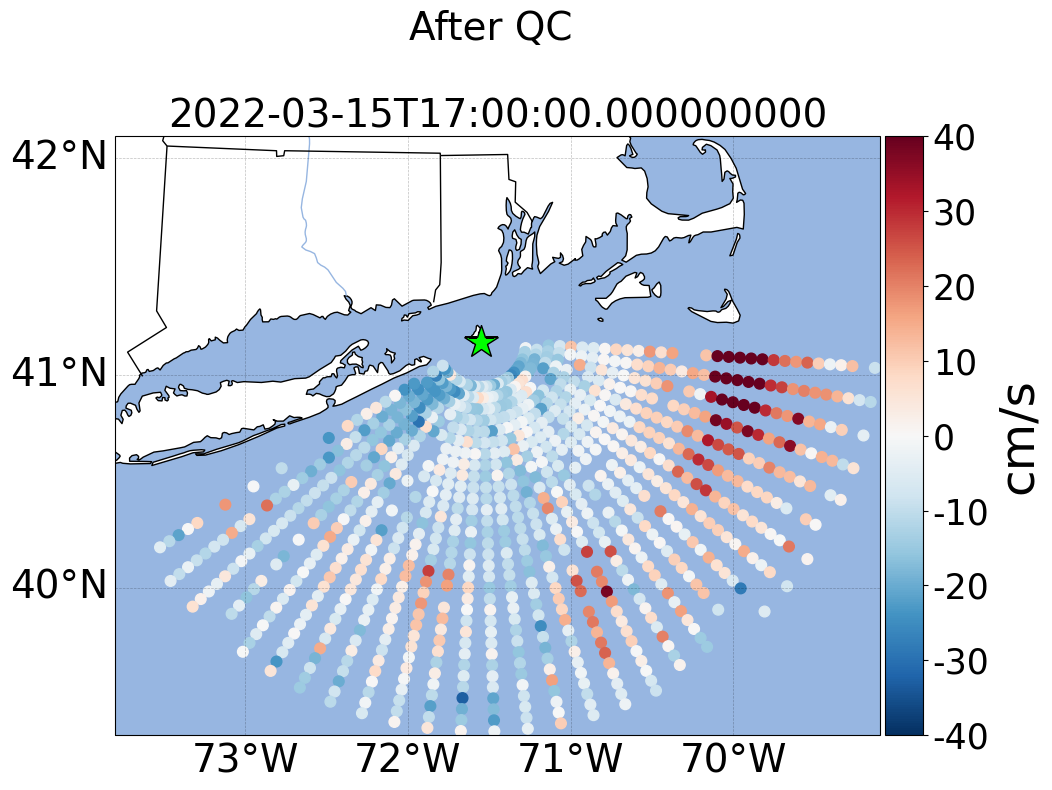

In [13]:
offset = TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)

fig, ax = plt.subplots(
    figsize=(11, 8),
    subplot_kw=dict(projection=ccrs.Mercator())
)

# Plot title
plt.title(f'After QC \n \n{tds.time.data}', fontsize = 28)

# plot circles instead of arrows
scatter_args = dict(
    cmap='RdBu_r',
    c= velocity2,
    s=59,  # Adjust the size of the circles as needed
    transform=ccrs.PlateCarree(),
    norm=offset)

#h = ax.scatter(r.data['LOND'][::sub], r.data['LATD'][::sub], **scatter_args)
h = ax.scatter(tds.lon, tds.lat, **scatter_args)



map_features(ax)

# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('cm/s', fontsize = 35)

ax.tick_params(axis='both', labelsize=35)
cb.ax.tick_params(labelsize=25)
ax.plot( -71.55, 41.15, '*', markersize=25, markeredgecolor='black', color='lime', transform=ccrs.PlateCarree())
plt.tight_layout()
plt.savefig('passed_qc.png', bbox_inches='tight')
